In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import collections
import pydotplus 
import statistics 
import pandas as pd
import os
from datetime import date
from tqdm.notebook import tqdm
from IPython.display import Image  
import scikitplot as skplt
import wittgenstein as lw
from imblearn.over_sampling import SMOTE

from scipy.stats import pearsonr
from scipy.spatial.distance import pdist,  squareform
import scipy.stats as stats
from scipy.stats import randint as sp_randint

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay # For Model evaluation
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn import tree, metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import re

## Load the dataset

In [12]:
users = pd.read_csv('new_users.csv', lineterminator='\n', index_col=0)
#tweets = pd.read_csv('new_tweets.csv', lineterminator='\n', index_col=0)

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10458 entries, 0 to 10457
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            10458 non-null  int64  
 1   name               10457 non-null  object 
 2   lang               10458 non-null  object 
 3   bot                10458 non-null  int64  
 4   statuses_count     10458 non-null  int64  
 5   count              10458 non-null  int64  
 6   retweet_received   10458 non-null  int64  
 7   reply_received     10458 non-null  int64  
 8   favorite_received  10458 non-null  int64  
 9   hashtag_used       10458 non-null  int64  
 10  urls_used          10458 non-null  int64  
 11  mentions_used      10458 non-null  int64  
 12  favorite_avg       10458 non-null  float64
 13  retweet_avg        10458 non-null  float64
 14  reply_avg          10458 non-null  float64
 15  urls_avg           10458 non-null  float64
 16  mentions_avg       104

## Utility Functions

In [4]:
def discretize_data(dataset, variables): #mapping categorical into numerical
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [5]:
def report_score(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['bot', 'genuine_user']))

def report_scores(test_label, test_pred, test_pred_w, test_pred_o):
    report_score(test_label, test_pred)
    report_score(test_label, test_pred_w)
    #report_score(test_label, test_pred_o)

In [71]:
def plot_confusion_matrix(test_label, test_pred, test_pred_w):
    # fig = plt.figure()
    # fig_dims = (1,2)
    # fig.subplots_adjust(hspace=0.4, wspace=0.4)

    #fig 1
    cm = confusion_matrix(test_label, test_pred, labels=[1,0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Bot', 'Genuine_User'])
    disp.plot()
    #plt.subplot2grid(fig_dims, (0,0))

    
    #fig 2
    cm_w = confusion_matrix(test_label, test_pred_w, labels=[1,0])
    disp_w = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Bot', 'Genuine_User'])
    disp_w.plot()
    #plt.subplot2grid(fig_dims, (0,1))

    #fig 3
    # cm_o = confusion_matrix(test_label, test_pred, labels=[1,0])
    # disp_o = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Bot', 'Genuine_User'])
    # disp_o.plot()
    #plt.show()

In [7]:
def spot_errors(test_label, test_pred):
    spotted_errors = []
    for i in range(len(test_label)):
        if(test_label.array[i]!= test_pred[i]):
            spotted_errors.append('darkred')
        else:
            spotted_errors.append('darkgray')
    return spotted_errors

def plot_prediction_data(test_set, test_label, test_pred, classifier_name, x, y):
    fig, (test_true_plt, test_pred_plt, errors_plt) = plt.subplots(1,3, figsize=(18,6), sharey=True)
    title = classifier_name + ' | Real vs Predicted labels'
    plt.suptitle(title)
    test_true_plt.set_title('True Label')
    test_true_plt.set_xlabel(x)
    test_true_plt.set_ylabel(y)
    test_true_plt.scatter(test_set[x].values, test_set[y].values, c=test_label.values, s=25, cmap='viridis')
    test_pred_plt.set_title('Predicted Label')
    test_pred_plt.set_xlabel(x)
    test_pred_plt.scatter(test_set[x].values, test_set[y].values, c=test_pred, s=25, cmap='viridis')
    spotted_errors = spot_errors(test_label, test_pred)
    errors_plt.set_title('Misclassification')
    errors_plt.set_xlabel(x)
    errors_plt.scatter(test_set[x].values, test_set[y].values, c=spotted_errors, s=25, cmap='viridis')
    plt.show()

## Preliminaries

### Filtering Dataset Attribute to classification

In [14]:
columns = ['lang']
data = discretize_data(users, columns)
data

user_id                name lang  bot  statuses_count  count  \
0      2353593986     Lamonica Raborn   en    1             132    132   
1      2358850842       Lourie Botton   en    0             122    122   
2       466124818      Carletto Focia   it    1            1439   1439   
3      2571493866           MBK Ebook   en    0            7085   3656   
4      2199062688                  Qq   en    0            7406   2081   
...           ...                 ...  ...  ...             ...    ...   
10453  1901595415        Prity Baleja   en    0             418    418   
10454  2911861962  Madrid Lae Maika .   en    0            1126   1120   
10455  1378532629           Clau Sato   en    0            3024   2088   
10456  2383025796     Minnie Guadagno   en    1             105    105   
10457   933183398           Corvanna    en    0            5279   3694   

       retweet_received  reply_received  favorite_received  hashtag_used  ...  \
0                     5               0                  5            13  ...   
1                     3               0                  6             4  ...   
2                  1190               0                259           107  ...   
3                    62               0                226           479  ...   
4                 31810               0               1260            54  ...   
...                 ...             ...                ...           ...  ...   
10453              1601               0                 89           566  ...   
10454             19585               0                 66           245  ...   
10455              7391               0                449           268  ...   
10456                 7               0                  9             1  ...   
10457             51901               0                478           164  ...   

       activity_period  Bot_Entropy  sub_year  sub_month  sub_day  \
0                    5     0.001426      2019          2       22   
1                    5          NaN      2019          2       26   
2                   30     0.001426      2017          1       18   
3                    4          NaN      2019          6       18   
4                   19          NaN      2018         11       19   
...                ...          ...       ...        ...      ...   
10453                4          NaN      2018          9       26   
10454                4          NaN      2019         11       29   
10455               31          NaN      2018          4       27   
10456                4     0.001426      2019          3       13   
10457                3          NaN      2017         11        9   

       retweet_max  reply_max  favorite_max  interaction_count  lang_num  
0              1.0        0.0           1.0                  9         4  
1              1.0        0.0           1.0                  9         4  
2            364.0        0.0          11.0                238        11  
3              3.0        0.0           2.0                246         4  
4            390.0        0.0          12.0               1643         4  
...            ...        ...           ...                ...       ...  
10453        303.0        0.0           5.0                143         4  
10454        391.0        0.0           3.0                249         4  
10455        395.0        0.0           4.0                441         4  
10456          2.0        0.0           1.0                 11         4  
10457        391.0        0.0           4.0               2064         4  

[10458 rows x 30 columns]

In [15]:
#drop the categorical variables since we don't need them anymore 
data.drop(columns=['lang', 'name', 'Bot_Entropy', 'sub_day', 'sub_month', 'sub_day', 'favorite_avg', 'reply_avg', 'retweet_avg', 'statuses_count'], axis=1,inplace=True)

### Creation of train and test dataset

In [10]:
label = data.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(data, label, stratify=label, test_size=0.30)

### Creation of normalize train and test set

In [20]:
norm_columns = ['user_id', 'count', 'retweet_received', 'reply_received', 'favorite_received', 'hashtag_used', 'urls_used',
       'mentions_used', 'urls_avg', 'mentions_avg', 'hashtags_avg',
       'avg_lenght', 'tweets_per_year', 'activity_period', 'sub_year',
       'retweet_max', 'reply_max', 'favorite_max', 'interaction_count',
       'lang_num']
norm_train_set = train_set[norm_columns]
norm_test_set  = test_set[norm_columns]

norm_train_set[norm_columns] = MinMaxScaler().fit_transform(train_set)
norm_test_set[norm_columns] = MinMaxScaler().fit_transform(test_set)

In [53]:
weights = {0:1.0, 1:100.0}
balance = [{0:1,1:5}, {0:1,1:10}, {0:1,1:15}, {0:1, 1:20}, {0:1, 1:30}, {0:1,1:50}, {0:1,1:100}, 'balanced']

## Classification

### Decision Tree Classification

##### Unbalanced Classification

In [31]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

In [32]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['bot', 'genuine_user'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [33]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

##### Weighted Classification

In [58]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, class_weight=weights)
dt = dt.fit(train_set, train_label)

In [59]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
param_grid = dict(class_weight=balance)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [60]:
grid_result = grid_search.fit(train_set, train_label)

In [61]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.864012 using {'class_weight': 'balanced'}
0.860721 (0.008444) with: {'class_weight': {0: 1, 1: 5}}
0.859458 (0.010112) with: {'class_weight': {0: 1, 1: 10}}
0.854441 (0.008855) with: {'class_weight': {0: 1, 1: 15}}
0.854043 (0.009160) with: {'class_weight': {0: 1, 1: 20}}
0.852103 (0.009323) with: {'class_weight': {0: 1, 1: 30}}
0.836931 (0.024477) with: {'class_weight': {0: 1, 1: 50}}
0.808226 (0.014126) with: {'class_weight': {0: 1, 1: 100}}
0.864012 (0.007283) with: {'class_weight': 'balanced'}


In [27]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, class_weight=grid_result.best_params_['class_weight'])
dt = dt.fit(train_set, train_label)

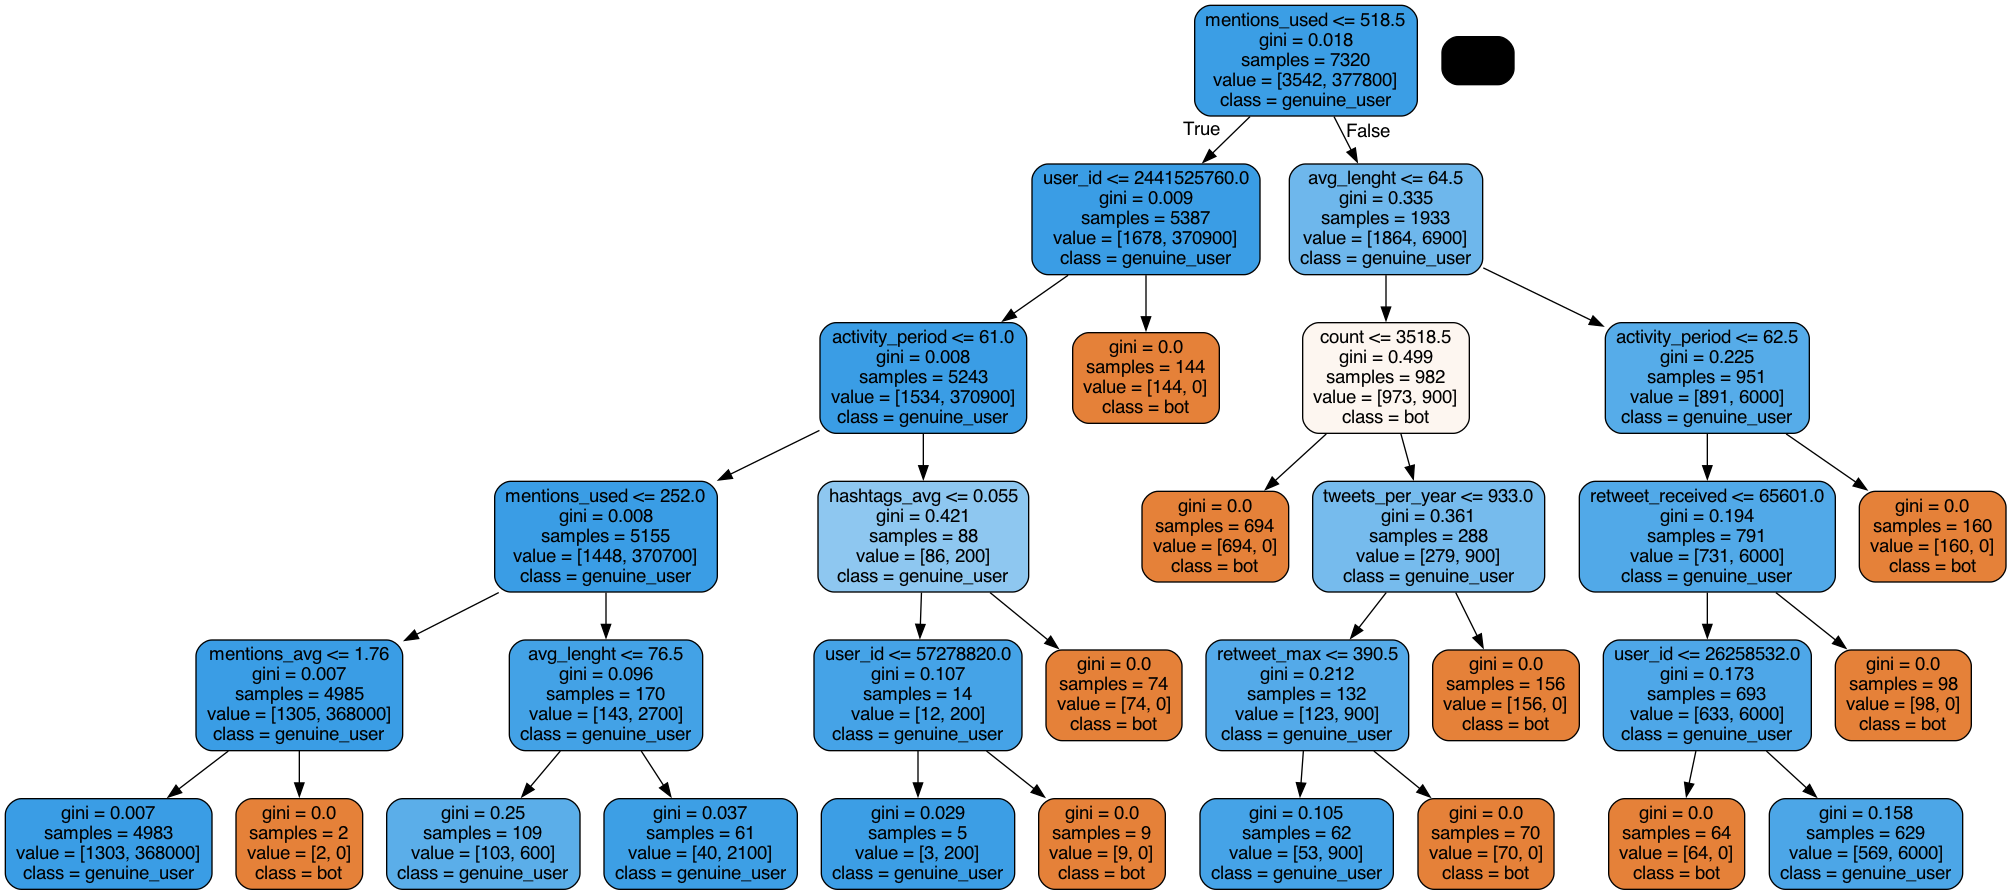

In [62]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['bot', 'genuine_user'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [63]:
train_pred_dt_w = dt.predict(train_set)
test_pred_dt_w = dt.predict(test_set)

##### Oversampling Classification with SMOTE

##### Evaluation of Decision Tree Classification

In [95]:
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.8542349726775956
Accuracy test set  0.8444869343530912
Precision train set  0.8729611318015041
Recall train set  0.8542349726775956
F1 score train set  0.8517381379895673
Support train set  (array([0.95748614, 0.79371614]), array([0.7312253 , 0.96956061]), array([0.82919802, 0.87287025]), array([3542, 3778]))


In [64]:
report_scores(train_label, train_pred_dt, train_pred_dt_w, None)

              precision    recall  f1-score   support

         bot       0.96      0.68      0.80      3542
genuine_user       0.76      0.97      0.86      3778

    accuracy                           0.83      7320
   macro avg       0.86      0.83      0.83      7320
weighted avg       0.86      0.83      0.83      7320

              precision    recall  f1-score   support

         bot       1.00      0.42      0.59      3542
genuine_user       0.65      1.00      0.78      3778

    accuracy                           0.72      7320
   macro avg       0.82      0.71      0.69      7320
weighted avg       0.82      0.72      0.69      7320



In [66]:
report_scores(test_label, test_pred_dt, test_pred_dt_w, None)

              precision    recall  f1-score   support

         bot       0.95      0.67      0.78      1518
genuine_user       0.76      0.97      0.85      1620

    accuracy                           0.82      3138
   macro avg       0.85      0.82      0.82      3138
weighted avg       0.85      0.82      0.82      3138

              precision    recall  f1-score   support

         bot       0.99      0.41      0.58      1518
genuine_user       0.64      1.00      0.78      1620

    accuracy                           0.71      3138
   macro avg       0.82      0.70      0.68      3138
weighted avg       0.81      0.71      0.69      3138



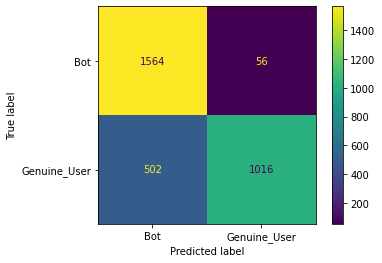

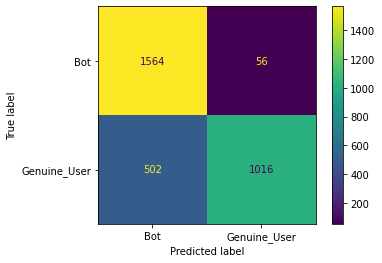

In [72]:
plot_confusion_matrix(test_label, test_pred_dt, test_pred_dt_w)

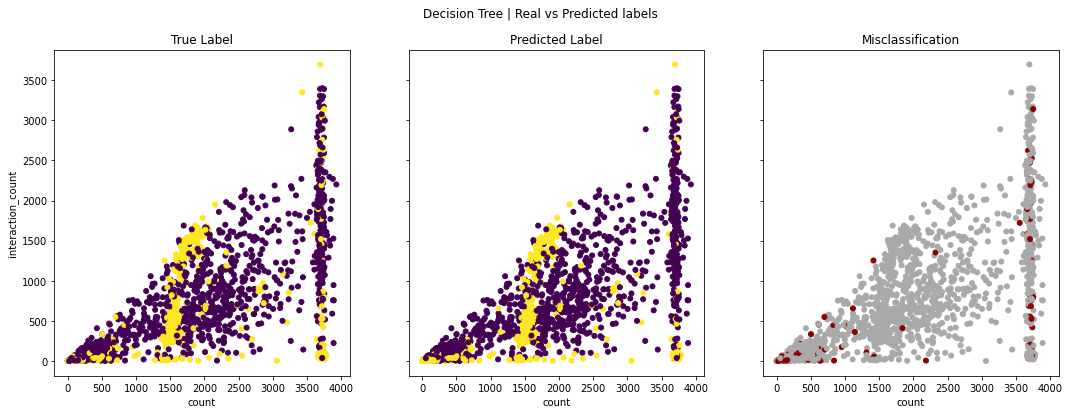

In [99]:
plot_prediction_data(test_set, test_label, test_pred_dt, 'Decision Tree', 'count', 'interaction_count')

### Gaussian Naive Bayes Classification

##### Unbalanced Classification

In [100]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

GaussianNB()

In [101]:
train_pred_gnb = gnb.predict(train_set)

In [102]:
test_pred_gnb = gnb.predict(test_set)

##### Weighted Classification (??????)

##### Oversampling Classification with SMOTE

##### Gaussian Naive Bayes evaluation

In [103]:
report_scores(train_label, train_pred_gnb)

              precision    recall  f1-score   support

         bot       0.97      0.21      0.34      3542
genuine_user       0.57      0.99      0.73      3778

    accuracy                           0.61      7320
   macro avg       0.77      0.60      0.54      7320
weighted avg       0.76      0.61      0.54      7320



In [104]:
#compute the performance of the model
report_scores(test_label, test_pred_gnb)

              precision    recall  f1-score   support

         bot       0.95      0.23      0.37      1518
genuine_user       0.58      0.99      0.73      1620

    accuracy                           0.62      3138
   macro avg       0.77      0.61      0.55      3138
weighted avg       0.76      0.62      0.55      3138



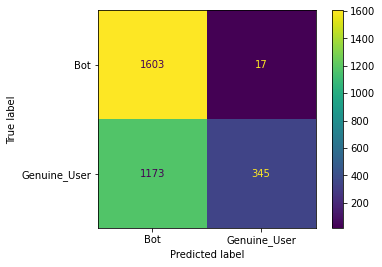

In [105]:
plot_confusion_mx(test_label, test_pred_gnb)

In [106]:
plot_prediction_data(test_set, test_label, test_pred_gnb, 'Decision Tree', 'count', 'interaction_count')

### Random Forest Classification

##### Unbalanced Classification

Searching for best parameters setting

In [107]:
#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=10,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.3, 1: 0.7}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14fd61cf0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14fce6740>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14fce4c70>},
                   scoring=make_scorer(accuracy_score))

In [108]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 50, 'min_samples_split': 37}
Mean and std of this setting  0.842896174863388 0.009708108199147449


Now we can apply the model with the best parameters setting

In [80]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=14,
                             max_depth=2, 
                             min_samples_split=18,
                             min_samples_leaf=43,
                             bootstrap=False) 
rf = rf.fit(train_set, train_label)

In [81]:
#prediction on the test test
train_pred_rf = rf.predict(train_set)

In [82]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

##### Weighted Classification

Searching for best parameters...

In [73]:
clf=RandomForestClassifier(n_estimators=100, class_weight=None)
# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_set,train_label)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = dict(class_weight=balance)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

grid_result = grid_search.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.874414 using {'class_weight': 'balanced'}
0.873534 (0.013851) with: {'class_weight': {0: 1, 1: 5}}
0.873688 (0.013874) with: {'class_weight': {0: 1, 1: 10}}
0.873282 (0.013077) with: {'class_weight': {0: 1, 1: 15}}
0.873501 (0.013022) with: {'class_weight': {0: 1, 1: 20}}
0.873538 (0.012801) with: {'class_weight': {0: 1, 1: 30}}
0.872758 (0.013143) with: {'class_weight': {0: 1, 1: 50}}
0.873692 (0.013459) with: {'class_weight': {0: 1, 1: 100}}
0.874414 (0.013024) with: {'class_weight': 'balanced'}


Let's apply the classifier with the best parameters found:

In [74]:
clf=RandomForestClassifier(n_estimators=100, class_weight=grid_result.best_params_['class_weight'])
clf.fit(train_set,train_label)


RandomForestClassifier(class_weight='balanced')

In [77]:
y_pred=clf.predict(test_set)

train_pred_rf_w = clf.predict(train_set)

test_pred_rf_w = clf.predict(test_set)

##### Random Forest Classification evaluation

In [84]:
report_scores(train_label, train_pred_rf, train_pred_rf_w, None)

              precision    recall  f1-score   support

         bot       0.94      0.65      0.77      3542
genuine_user       0.75      0.96      0.84      3778

    accuracy                           0.81      7320
   macro avg       0.84      0.81      0.80      7320
weighted avg       0.84      0.81      0.80      7320

              precision    recall  f1-score   support

         bot       1.00      1.00      1.00      3542
genuine_user       1.00      1.00      1.00      3778

    accuracy                           1.00      7320
   macro avg       1.00      1.00      1.00      7320
weighted avg       1.00      1.00      1.00      7320



In [86]:
report_scores(test_label, test_pred_rf, test_pred_rf_w, None)

              precision    recall  f1-score   support

         bot       0.93      0.65      0.76      1518
genuine_user       0.74      0.95      0.83      1620

    accuracy                           0.81      3138
   macro avg       0.84      0.80      0.80      3138
weighted avg       0.83      0.81      0.80      3138

              precision    recall  f1-score   support

         bot       0.91      0.69      0.78      1518
genuine_user       0.76      0.93      0.84      1620

    accuracy                           0.81      3138
   macro avg       0.83      0.81      0.81      3138
weighted avg       0.83      0.81      0.81      3138



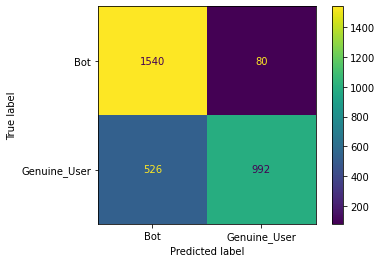

In [114]:
plot_confusion_mx(test_label, test_pred_rf)

In [115]:
plot_prediction_data(test_set, test_label, test_pred_rf, 'Decision Tree', 'count', 'interaction_count')

### AdaBoost Classfication

In [116]:
clf = AdaBoostClassifier()
clf.fit(train_set, train_label)

AdaBoostClassifier()

In [117]:
train_pred_clf = clf.predict(train_set)

In [118]:
test_pred_clf = clf.predict(test_set)

##### Evaluation of AdaBoost Classification

In [119]:
report_scores(train_label, train_pred_clf)

              precision    recall  f1-score   support

         bot       0.96      0.73      0.83      3542
genuine_user       0.80      0.97      0.87      3778

    accuracy                           0.86      7320
   macro avg       0.88      0.85      0.85      7320
weighted avg       0.87      0.86      0.85      7320



In [120]:
report_scores(test_label, test_pred_clf)

              precision    recall  f1-score   support

         bot       0.94      0.73      0.82      1518
genuine_user       0.79      0.96      0.87      1620

    accuracy                           0.85      3138
   macro avg       0.87      0.84      0.84      3138
weighted avg       0.86      0.85      0.85      3138



In [121]:
plot_confusion_mx(test_label, test_pred_clf)

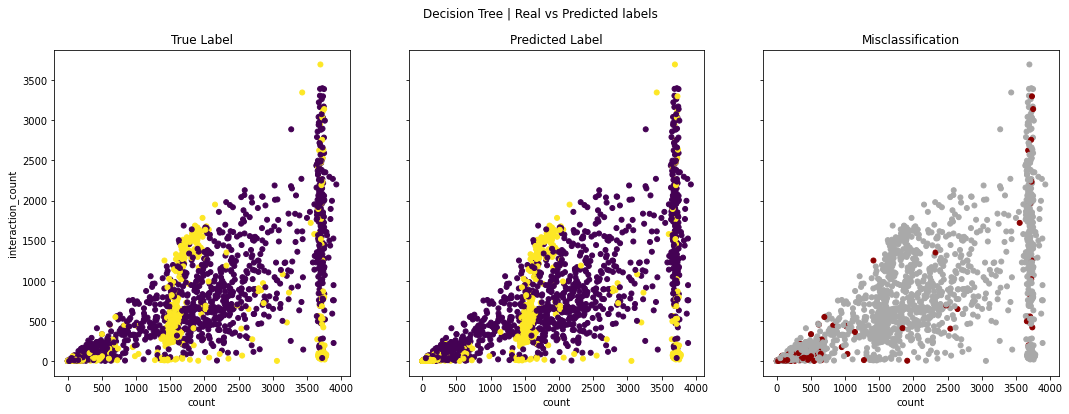

In [122]:
plot_prediction_data(test_set, test_label, test_pred_clf, 'Decision Tree', 'count', 'interaction_count')

#### AdaBoost with base classifier

In [123]:
#TODO: rivedere parametro max_depth
base = tree.DecisionTreeClassifier(max_depth=2)
clf = AdaBoostClassifier(base_estimator=base, n_estimators=200, learning_rate=0.1)
clf.fit(train_set, train_label)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1, n_estimators=200)

In [124]:
train_pred_clf = clf.predict(train_set)

In [125]:
test_pred_clf = clf.predict(test_set)

##### Evaluation of AdaBoost with base classifier

In [126]:
report_scores(train_label, train_pred_clf)

              precision    recall  f1-score   support

         bot       0.99      0.75      0.85      3542
genuine_user       0.81      0.99      0.89      3778

    accuracy                           0.87      7320
   macro avg       0.90      0.87      0.87      7320
weighted avg       0.89      0.87      0.87      7320



In [127]:
report_scores(test_label, test_pred_clf)

              precision    recall  f1-score   support

         bot       0.96      0.74      0.83      1518
genuine_user       0.80      0.97      0.88      1620

    accuracy                           0.86      3138
   macro avg       0.88      0.85      0.85      3138
weighted avg       0.88      0.86      0.86      3138



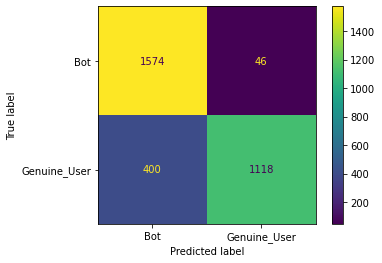

In [128]:
plot_confusion_mx(test_label, test_pred_clf)

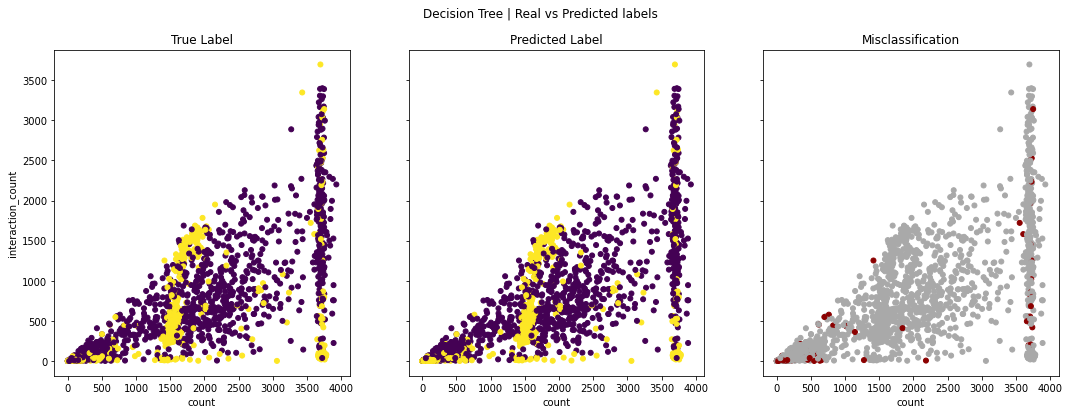

In [129]:
plot_prediction_data(test_set, test_label, test_pred_clf, 'Decision Tree', 'count', 'interaction_count')

### SVM Classification

##### Unbalanced Classification

In [132]:
svm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True)
svm.fit(train_set, train_label)

SVC(C=0.5, kernel='sigmoid', probability=True)

In [133]:
train_pred_svm = svm.predict(train_set)

In [134]:
test_pred_svm = svm.predict(test_set)

##### Weighted Classification

In [87]:
svm = SVC(gamma='scale', class_weight=weights)
svm.fit(train_set, train_label)


SVC(class_weight={0: 1.0, 1: 100.0})

In [88]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:10}, 'balanced']
param_grid = dict(class_weight=balance)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid_search.fit(train_set, train_label)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.708302 using {'class_weight': 'balanced'}


In [126]:
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


0.859098 (0.013350) with: {'class_weight': {0: 100, 1: 1}}
0.856972 (0.012657) with: {'class_weight': {0: 10, 1: 1}}
0.866935 (0.009899) with: {'class_weight': {0: 1, 1: 10}}
0.864665 (0.009533) with: {'class_weight': 'balanced'}


In [127]:
svm = SVC(gamma='scale', class_weight=grid_result.best_params_['class_weight'])
svm.fit(train_set, train_label)


SVC(class_weight={0: 1, 1: 10})

In [131]:
train_pred_svm_w = svm.predict(train_set)
test_pred_svm_w = svm.predict(test_set)

##### Oversampling Classification with SMOTE

##### Evaluation

In [135]:
report_scores(train_label, train_pred_svm, train_pred_svm_w, None)

              precision    recall  f1-score   support

         bot       0.61      0.49      0.54      3542
genuine_user       0.60      0.70      0.65      3778

    accuracy                           0.60      7320
   macro avg       0.60      0.60      0.59      7320
weighted avg       0.60      0.60      0.60      7320

              precision    recall  f1-score   support

         bot       0.99      0.62      0.76      3542
genuine_user       0.73      1.00      0.85      3778

    accuracy                           0.81      7320
   macro avg       0.86      0.81      0.80      7320
weighted avg       0.86      0.81      0.80      7320



In [139]:
report_scores(test_label, test_pred_svm, test_pred_svm_w, None)

              precision    recall  f1-score   support

         bot       0.57      0.54      0.56      1518
genuine_user       0.59      0.63      0.61      1620

    accuracy                           0.58      3138
   macro avg       0.58      0.58      0.58      3138
weighted avg       0.58      0.58      0.58      3138

              precision    recall  f1-score   support

         bot       0.99      0.63      0.77      1518
genuine_user       0.74      0.99      0.85      1620

    accuracy                           0.82      3138
   macro avg       0.87      0.81      0.81      3138
weighted avg       0.86      0.82      0.81      3138



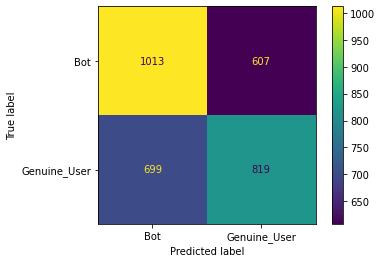

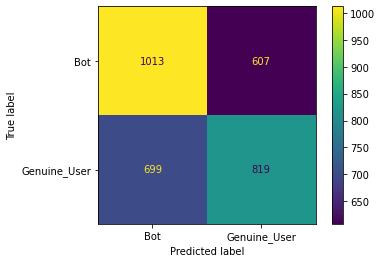

In [151]:
plot_confusion_matrix(test_label, test_pred_svm, test_pred_svm_w)

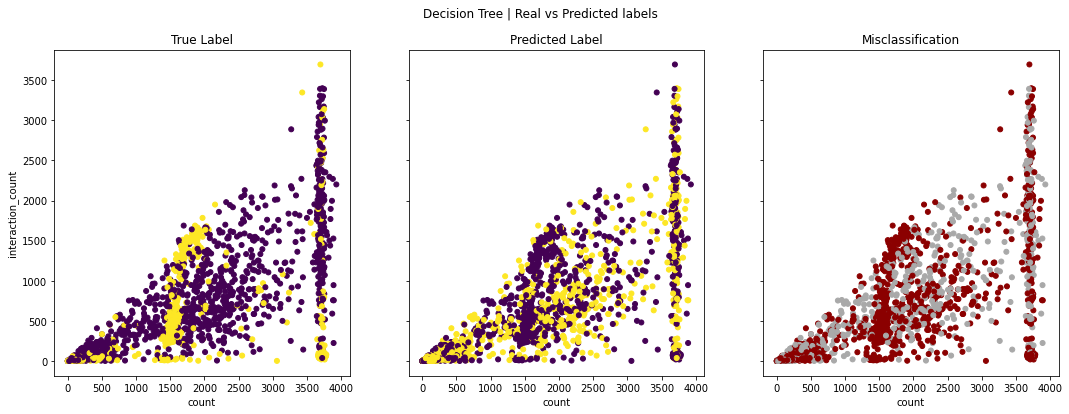

In [136]:
plot_prediction_data(test_set, test_label, test_pred_svm, 'Decision Tree', 'count', 'interaction_count')

### Rule Based Classification

In [137]:
#we searching for best configuration parameters
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(train_set, train_label)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

GridSearchCV(estimator=<RIPPER(n_discretize_bins=10, dl_allowance=64, max_rule_conds=None, prune_size=0.33, max_total_conds=None, max_rules=None, k=2, verbosity=0, random_state=None)>,
             param_grid={'k': [1, 3, 5], 'prune_size': [0.5, 0.6]})

In [138]:
#grid_result = grid_search.fit(train_set, train_label, pos_class=1)
grid_search.cv_results_['params'][0]

{'k': 1, 'prune_size': 0.5}

In [139]:
ripper = lw.RIPPER(k=1, prune_size=0.5)
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='bot', pos_class=1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

In [140]:
ripper.out_model()

[[urls_used=<3.0 ^ statuses_count=35.0-90.0 ^ mentions_avg=0.01-0.14 ^ favorite_received=1.0-3.0 ^ tweets_per_year=<5.27 ^ urls_avg=<0.02] V
[urls_used=<3.0 ^ statuses_count=<35.0 ^ interaction_count=<2.0 ^ activity_period=19.0-23.0] V
[urls_used=<3.0 ^ activity_period=4.0-5.0 ^ statuses_count=90.0-111.0 ^ interaction_count=5.0-7.0 ^ favorite_received=3.0-5.0] V
[urls_used=<3.0 ^ statuses_count=90.0-111.0 ^ favorite_received=5.0-7.0] V
[retweet_max=<1.0 ^ mentions_avg=<0.01 ^ urls_used=>450.2] V
[urls_avg=<0.02 ^ mentions_avg=<0.01 ^ statuses_count=1150.4-2007.3] V
[urls_used=<3.0 ^ favorite_max=1.0-2.0 ^ avg_lenght=65.0-68.0 ^ statuses_count=35.0-90.0] V
[urls_used=<3.0 ^ statuses_count=111.0-132.0] V
[urls_used=<3.0 ^ retweet_received=<2.0 ^ statuses_count=35.0-90.0] V
[urls_used=<3.0 ^ statuses_count=90.0-111.0 ^ retweet_received=<2.0 ^ mentions_used=17.0-35.0] V
[urls_used=<3.0 ^ statuses_count=<35.0 ^ user_id=1128285022.0-2212991933.0] V
[urls_used=<3.0 ^ activity_period=4.0-5.0 ^

In [141]:
train_pred_ripper = ripper.predict(train_set)
test_pred_ripper = ripper.predict(test_set)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

##### Weighted Classification

In [106]:
#we run a grid search to find the best configuration of parameters' values
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5], "class_weight": balance}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)

grid_result = grid_search.fit(train_set, train_label, pos_class=1)
grid_result.best_params_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

{'class_weight': {0: 100, 1: 1}, 'k': 5, 'prune_size': 0.6}

In [110]:
ripper = lw.RIPPER(k=grid_result.best_params_['k'], prune_size=grid_result.best_params_['prune_size'])
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='ranked', pos_class=1, class_weight=grid_result.best_params_['class_weight'])

IndexError: Dataset does not include class feature name ranked. Training set features: Index(['user_id', 'count', 'retweet_received', 'reply_received',
       'favorite_received', 'hashtag_used', 'urls_used', 'mentions_used',
       'urls_avg', 'mentions_avg', 'hashtags_avg', 'avg_lenght',
       'tweets_per_year', 'activity_period', 'sub_year', 'retweet_max',
       'reply_max', 'favorite_max', 'interaction_count', 'lang_num', 'bot'],
      dtype='object')

In [ ]:
ripper.out_model()

In [ ]:
train_pred_ripper_w = ripper.predict(train_set)

test_pred_ripper_w = ripper.predict(test_set)

##### Evaluation

In [ ]:
report_scores(train_label, train_pred_ripper, train_pred_ripper_w)

              precision    recall  f1-score   support

         bot       0.88      0.73      0.80      3542
genuine_user       0.78      0.91      0.84      3778

    accuracy                           0.82      7320
   macro avg       0.83      0.82      0.82      7320
weighted avg       0.83      0.82      0.82      7320



In [ ]:
report_scores(test_label, test_pred_ripper, test_pred_ripper_w)

              precision    recall  f1-score   support

         bot       0.88      0.70      0.78      1518
genuine_user       0.77      0.91      0.83      1620

    accuracy                           0.81      3138
   macro avg       0.83      0.81      0.81      3138
weighted avg       0.82      0.81      0.81      3138



In [144]:
#evaluation of the performance of the classifier (test set)
# print('Accuracy ', ripper.score(test_set, test_label))
# print('Precision ', ripper.score(test_set, test_label, precision_score))
# print('Recall ', ripper.score(test_set, test_label, recall_score))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

Accuracy  0.8126195028680688


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

Precision  0.7676348547717843


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

Recall  0.9135802469135802


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

In [145]:
plot_confusion_mx(test_label, test_pred_ripper)

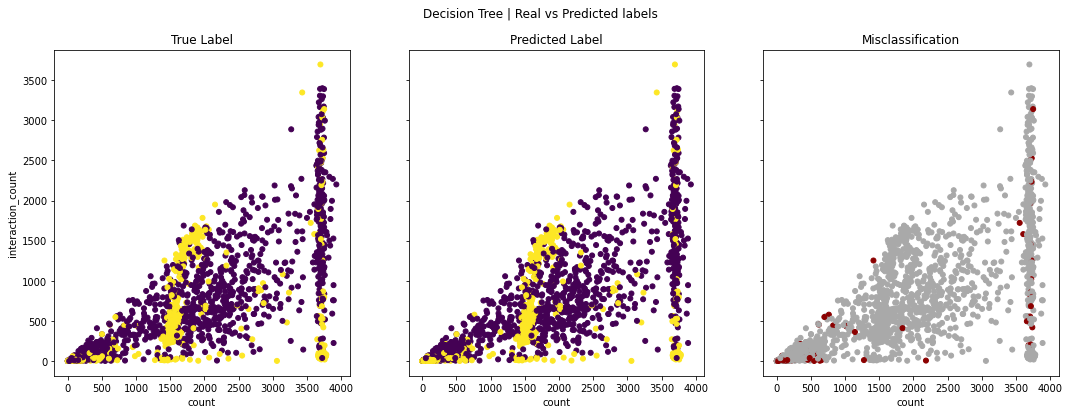

In [146]:
plot_prediction_data(test_set, test_label, test_pred_clf, 'Decision Tree', 'count', 'interaction_count')

### Neural Network Classification

In [95]:
import tensorflow as tf
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(1, len(train_set.columns))),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [96]:
x_train = np.reshape(norm_train_set.values, (len(norm_train_set), 1, len(norm_train_set.columns)))
history = model.fit(x_train, train_label,
                    epochs=80,
                    batch_size=8,
                    validation_split=0.2)

Epoch 1/80
732/732 [==============================] - 5s 4ms/step - loss: 0.4640 - accuracy: 0.7915 - val_loss: 0.4163 - val_accuracy: 0.8122
Epoch 2/80
732/732 [==============================] - 3s 4ms/step - loss: 0.4032 - accuracy: 0.8149 - val_loss: 0.4080 - val_accuracy: 0.8176
Epoch 3/80
732/732 [==============================] - 2s 3ms/step - loss: 0.3939 - accuracy: 0.8163 - val_loss: 0.4036 - val_accuracy: 0.8176
Epoch 4/80
732/732 [==============================] - 3s 4ms/step - loss: 0.3880 - accuracy: 0.8181 - val_loss: 0.4019 - val_accuracy: 0.8183
Epoch 5/80
732/732 [==============================] - 3s 5ms/step - loss: 0.3833 - accuracy: 0.8197 - val_loss: 0.3990 - val_accuracy: 0.8197
Epoch 6/80
732/732 [==============================] - 3s 4ms/step - loss: 0.3797 - accuracy: 0.8209 - val_loss: 0.3961 - val_accuracy: 0.8204
Epoch 7/80
732/732 [==============================] - 2s 3ms/step - loss: 0.3761 - accuracy: 0.8214 - val_loss: 0.3965 - val_accuracy: 0.8204
Epoch 

In [69]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 21)                0         
                                                                 
 dense_27 (Dense)            (None, 128)               2816      
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


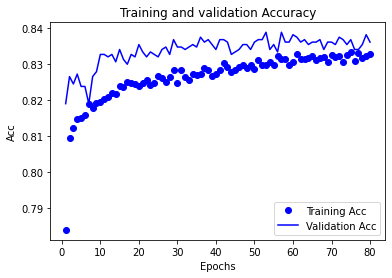

In [70]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [86]:
from matplotlib.pyplot import figure
fig, (acc_plot, loss_plot) = plt.subplots(2, figsize=(15, 6), dpi=240)
fig.suptitle('Accuracy and Loss trends')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
acc_plot.plot(epochs, acc, label='Training Acc')
acc_plot.plot(epochs, val_acc, label='Validation Acc')
acc_plot.legend(loc='best')
acc_plot.set_ylabel('Accuracy')
#acc_plot.set_ylim([0,1])
acc_plot.grid(True)
loss_plot.plot(epochs, loss, label='Trining Loss')
loss_plot.plot(epochs, val_loss, label='Validation Loss')
loss_plot.legend(loc='best')
loss_plot.set_ylabel('Loss')
#loss_plot.set_ylim([0,1])
loss_plot.set_xlabel('Epochs')
loss_plot.grid(True)

In [97]:
x_train_test = np.reshape(norm_train_set.values, (len(norm_train_set), 1, len(train_set.columns)))
train_pred_nn = (model.predict(x_train_test) > 0.5).astype("int32")

229/229 [==============================] - 0s 1ms/step


In [98]:
x_test = np.reshape(norm_test_set.values, (len(norm_test_set), 1, len(norm_test_set.columns)))
test_pred_nn = (model.predict(x_test) > 0.5).astype("int32")

99/99 [==============================] - 0s 1ms/step


##### Weighted Classification

In [89]:
from sklearn.utils import class_weight
weights_nn = {0: 0.75, 1: 3.5}
class_weights = class_weight.compute_class_weight(class_weight = weights_nn,
                                                 classes = np.unique(train_label),
                                                 y = train_label)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.75, 1: 3.5}


In [90]:
import tensorflow as tf
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(1, len(train_set.columns))),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-01-02 16:34:34.499633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 16:34:47.782793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [91]:
x_train = np.reshape(norm_train_set.values, (len(norm_train_set), 1, len(norm_train_set.columns)))
history = model.fit(x_train, train_label,
                    epochs=80,
                    batch_size=8,
                    validation_split=0.2,
                    class_weight=class_weights,)

Epoch 1/80
732/732 [==============================] - 5s 4ms/step - loss: 0.6822 - accuracy: 0.7285 - val_loss: 0.5514 - val_accuracy: 0.8012
Epoch 2/80
732/732 [==============================] - 2s 3ms/step - loss: 0.5466 - accuracy: 0.8019 - val_loss: 0.6051 - val_accuracy: 0.7889
Epoch 3/80
732/732 [==============================] - 2s 3ms/step - loss: 0.5299 - accuracy: 0.8069 - val_loss: 0.5612 - val_accuracy: 0.7985
Epoch 4/80
732/732 [==============================] - 2s 3ms/step - loss: 0.5257 - accuracy: 0.8069 - val_loss: 0.5779 - val_accuracy: 0.7964
Epoch 5/80
732/732 [==============================] - 3s 5ms/step - loss: 0.5175 - accuracy: 0.8093 - val_loss: 0.4772 - val_accuracy: 0.8115
Epoch 6/80
732/732 [==============================] - 5s 7ms/step - loss: 0.5143 - accuracy: 0.8091 - val_loss: 0.5250 - val_accuracy: 0.8067
Epoch 7/80
732/732 [==============================] - 4s 6ms/step - loss: 0.5078 - accuracy: 0.8105 - val_loss: 0.4945 - val_accuracy: 0.8115
Epoch 

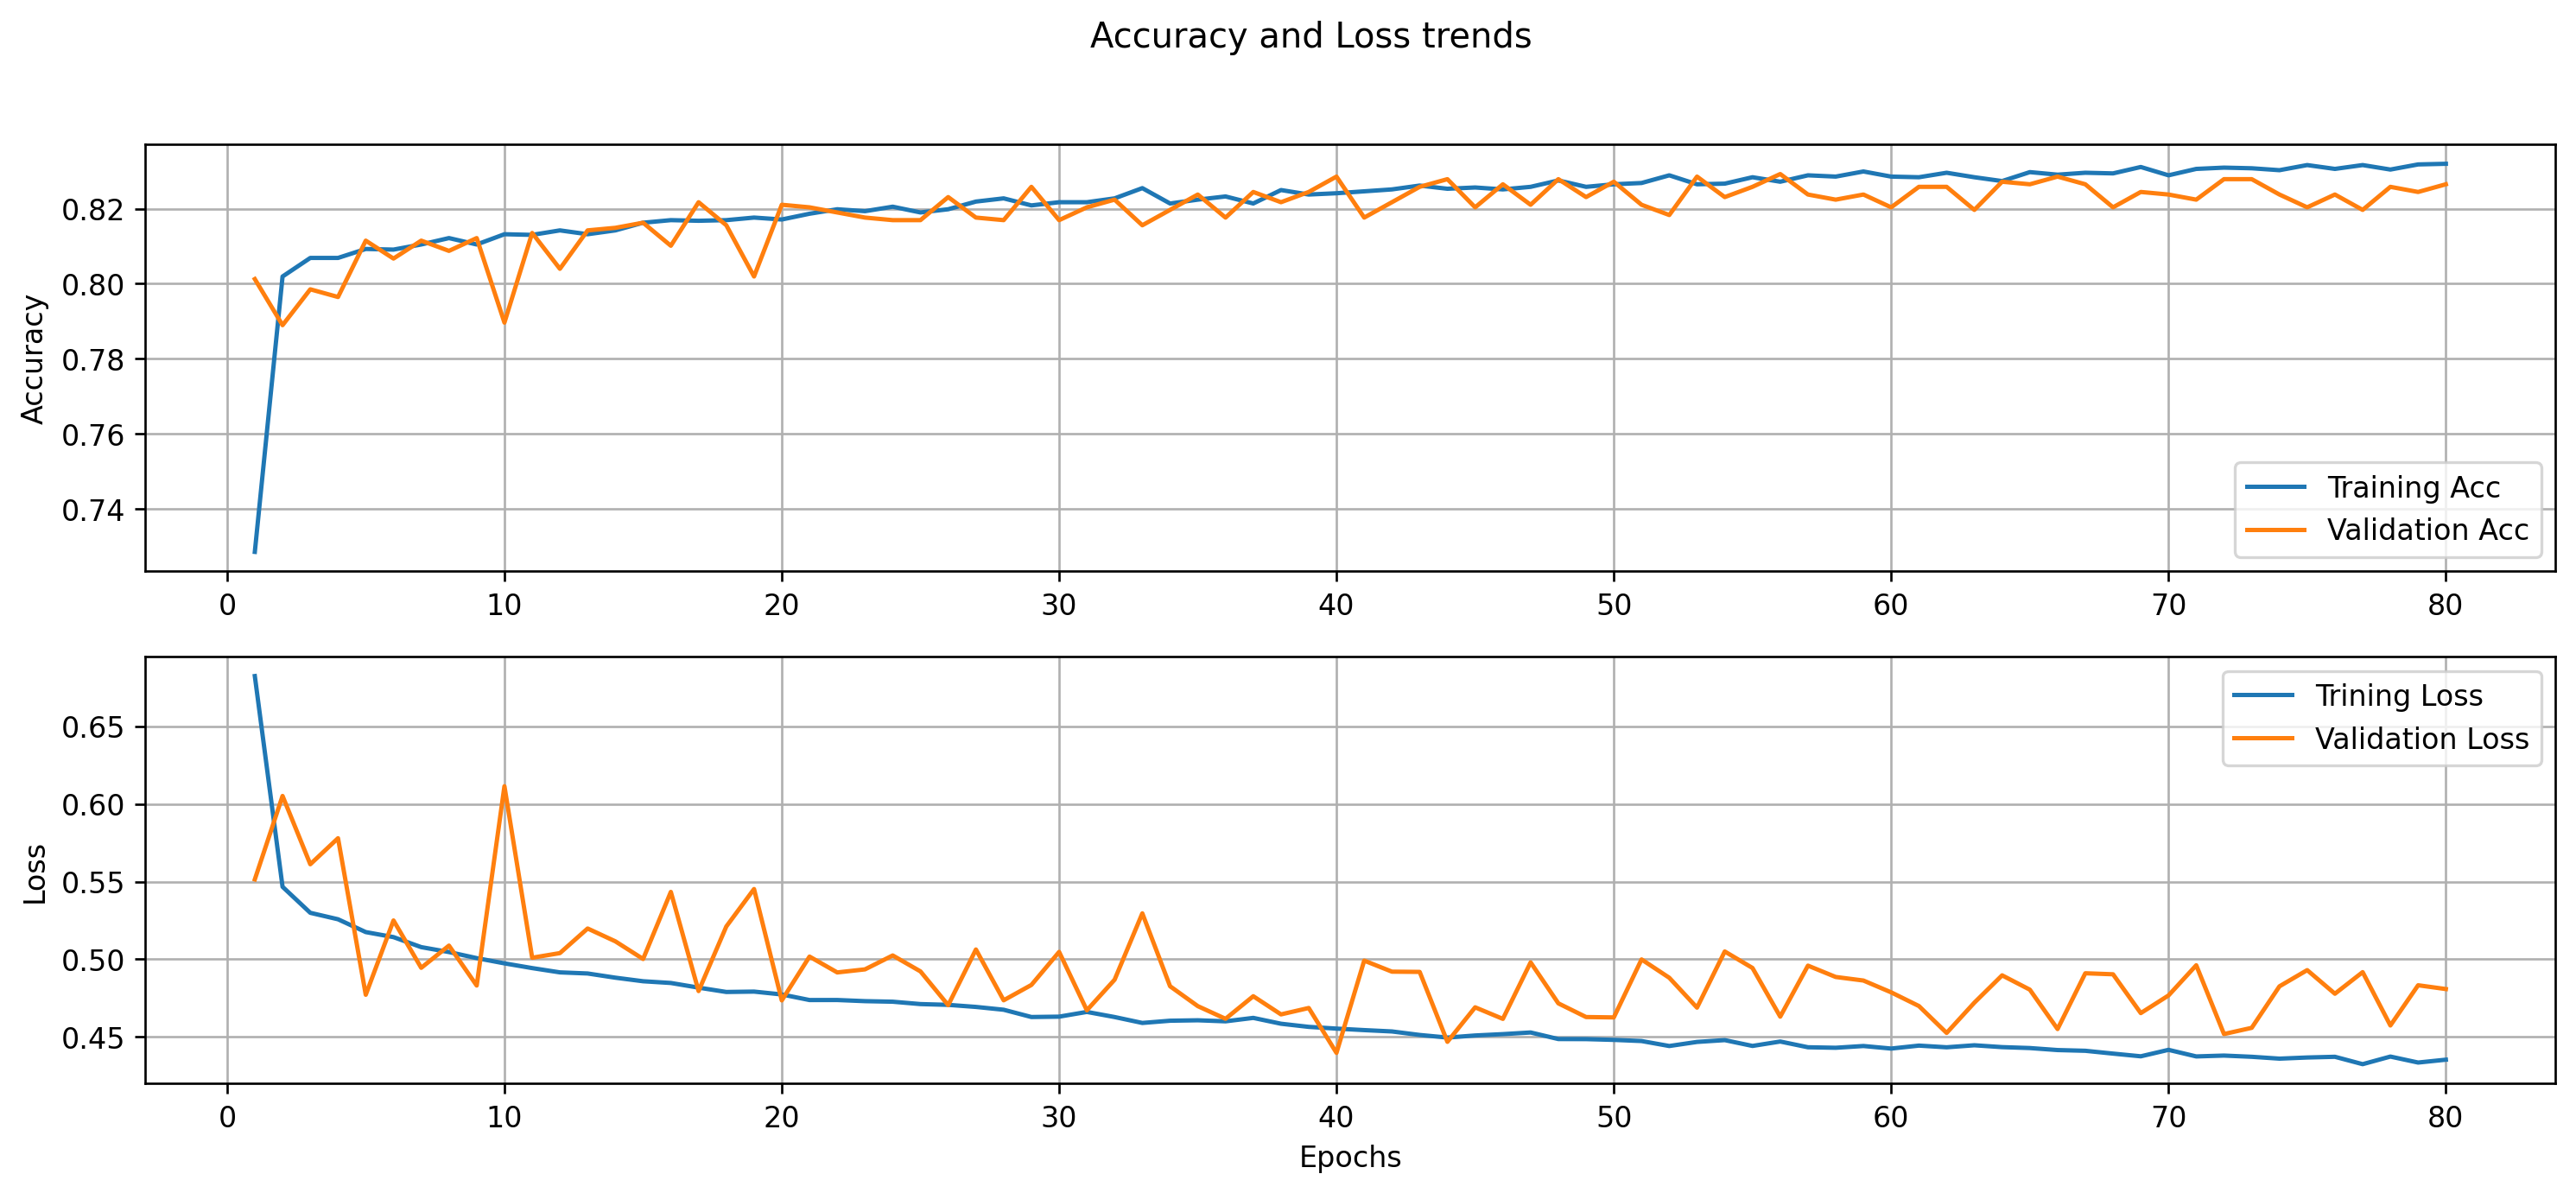

In [92]:
from matplotlib.pyplot import figure
fig, (acc_plot, loss_plot) = plt.subplots(2, figsize=(15, 6), dpi=240)
fig.suptitle('Accuracy and Loss trends')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
acc_plot.plot(epochs, acc, label='Training Acc')
acc_plot.plot(epochs, val_acc, label='Validation Acc')
acc_plot.legend(loc='best')
acc_plot.set_ylabel('Accuracy')
#acc_plot.set_ylim([0,1])
acc_plot.grid(True)
loss_plot.plot(epochs, loss, label='Trining Loss')
loss_plot.plot(epochs, val_loss, label='Validation Loss')
loss_plot.legend(loc='best')
loss_plot.set_ylabel('Loss')
#loss_plot.set_ylim([0,1])
loss_plot.set_xlabel('Epochs')
loss_plot.grid(True)

In [93]:
x_train_test = np.reshape(norm_train_set.values, (len(norm_train_set), 1, len(train_set.columns)))
train_pred_nn_w = (model.predict(x_train_test) > 0.5).astype("int32")

229/229 [==============================] - 1s 4ms/step


In [94]:
x_test = np.reshape(norm_test_set.values, (len(norm_test_set), 1, len(norm_test_set.columns)))
test_pred_nn_w = (model.predict(x_test) > 0.5).astype("int32")

99/99 [==============================] - 0s 4ms/step


##### Evaluation

In [104]:
report_scores(train_label, train_pred_nn, train_pred_nn_w, None)

              precision    recall  f1-score   support

         bot       0.97      0.69      0.81      3542
genuine_user       0.77      0.98      0.86      3778

    accuracy                           0.84      7320
   macro avg       0.87      0.84      0.83      7320
weighted avg       0.87      0.84      0.84      7320

              precision    recall  f1-score   support

         bot       0.99      0.66      0.79      3542
genuine_user       0.76      0.99      0.86      3778

    accuracy                           0.83      7320
   macro avg       0.87      0.83      0.83      7320
weighted avg       0.87      0.83      0.83      7320



In [100]:
report_scores(test_label, test_pred_nn, test_pred_nn_w, None)

              precision    recall  f1-score   support

         bot       0.94      0.68      0.79      1518
genuine_user       0.76      0.96      0.85      1620

    accuracy                           0.82      3138
   macro avg       0.85      0.82      0.82      3138
weighted avg       0.85      0.82      0.82      3138

              precision    recall  f1-score   support

         bot       0.96      0.66      0.79      1518
genuine_user       0.76      0.98      0.85      1620

    accuracy                           0.83      3138
   macro avg       0.86      0.82      0.82      3138
weighted avg       0.86      0.83      0.82      3138



In [83]:
plot_confusion_mx(test_label, test_pred_nn)

In [112]:
plot_prediction_data(test_set, test_label, test_pred_nn, 'Decision Tree', 'count', 'interaction_count')

### K-Nearest Neighbour Classification

In [101]:
# knn_train_set = train_set.drop(columns=['sub_year', 'lang_num'])
# knn_test_set = train_set.drop(columns=['sub_year', 'lang_num'])

In [102]:
k_range = range(1, 31)
knn_metrics = ['euclidean', 'manhattan']
knn_weights = ['uniform', 'distance']
knn_algorithms = ['ball_tree', 'kd_tree', 'brute']

knn_param_grid = {
    'n_neighbors': k_range,
    'metric': knn_metrics,
    'algorithm': knn_algorithms,
    'weights': knn_weights
}

In [103]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
knn_grid.fit(train_set, train_label)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [104]:
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.8151639344262295
Parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}


In [106]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(train_set, train_label)

In [107]:
train_pred_knn = knn.predict(train_set)
report_scores(train_label, train_pred_knn)

              precision    recall  f1-score   support

         bot       0.95      0.66      0.78      3542
genuine_user       0.75      0.97      0.85      3778

    accuracy                           0.82      7320
   macro avg       0.85      0.82      0.81      7320
weighted avg       0.85      0.82      0.82      7320



In [108]:
test_pred_knn = knn.predict(test_set)
report_scores(test_label, test_pred_knn)

              precision    recall  f1-score   support

         bot       0.94      0.68      0.79      1518
genuine_user       0.76      0.96      0.85      1620

    accuracy                           0.83      3138
   macro avg       0.85      0.82      0.82      3138
weighted avg       0.85      0.83      0.82      3138



In [109]:
plot_confusion_mx(test_label, test_pred_nn)

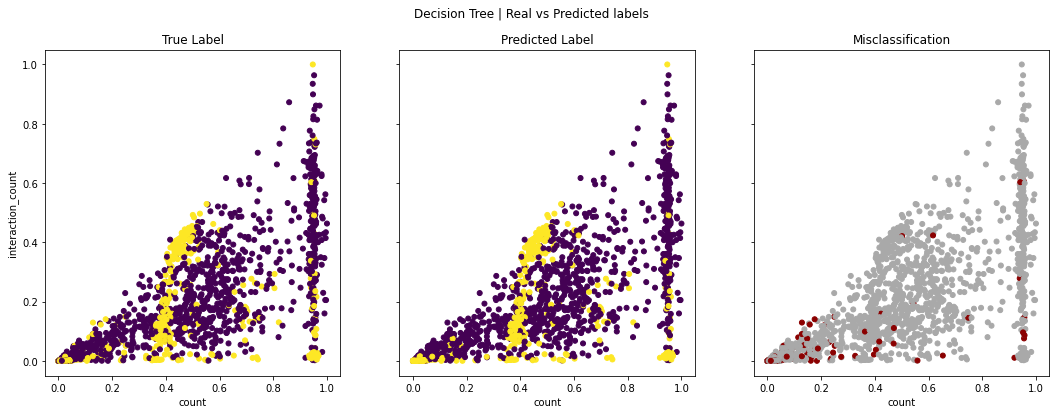

In [111]:
plot_prediction_data(test_set, test_label, test_pred_knn, 'Decision Tree', 'count', 'interaction_count')

## Final Evaluation